# ABCD - The Simple Case
A very simple ABCD method calculation: Build a dataset, define a cut, and then predict A from B, C, and D. The variables created are totally uncorrelated.

We define ABCD as A in the upper left hand quadrant, B in the lower left hand, C in the upper right hand and D in the lower right hand:

       +----+----+
       |  A |  C |
    v2 +----+----+
       |  B +  D |
       +---------+
           v1
   
 Thus, the ratio is A/B = C/D or A = BC/D.
 
     A: v1 <= xcut & v2 > ycut
     B: v1 <= xcut & v2 <= ycut
     C: v1 > xcut & v2 > ycut
     D: v1 > xcut & v2 <= ycut

## Initalization

In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Sample Generation

In [94]:
def generate(n):
  sample_np = np.random.rand(n, 2)
  return pd.DataFrame(sample_np, columns=['v1', 'v2'])

In [95]:
sample=generate(10000)

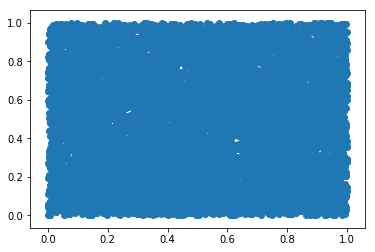

In [96]:
plt.scatter(sample['v1'], sample['v2'])

## ABCD Calculation

In [103]:
def calc_ABCD(sample, xc, yc):
    A = sample.loc[(sample['v1']<=xc) & (sample['v2']>yc)]
    B = sample.loc[(sample['v1']<=xc) & (sample['v2']<=yc)]
    C = sample.loc[(sample['v1']>xc) & (sample['v2']>yc)]
    D = sample.loc[(sample['v1']>xc) & (sample['v2']<=yc)]
    nA = len(A.index)
    nB = len(B.index)
    nC = len(C.index)
    nD = len(D.index)
    pred = nB*nC/nD
    fractionalError = abs(nA - pred)/nA
    return fractionalError

In [105]:
xcut = 0.5
ycut = 0.5
calc_ABCD(sample, xcut, ycut)

In [88]:
ycut = 0.5

In [101]:

fractionalError*100

2.746869325815781